# 0. Install dependencies

In [2]:
 #%pip install matplotlib tensorflow==2.5.0 tensorflow-io==0.19.1 

# 1. Import depndencies 

In [3]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [4]:
print("tensorflow version:", tf.__version__)
print("tensorflow_io version:", tfio.__version__)

tensorflow version: 2.5.0
tensorflow_io version: 0.19.1


# 2. Loading data

In [5]:
# Here we are loding only one file for testing purpose

CRY_FILE = os.path.join('data', 'cry', 'baby_cry (366).wav')
NOT_CRY_FILE = os.path.join('data', 'not_cry', 'noise (149).wav')

In [6]:
print(CRY_FILE)
print(NOT_CRY_FILE)

data\cry\baby_cry (366).wav
data\not_cry\noise (149).wav


# 3. Data loading function

In [7]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# 4. Plotting waveform

In [8]:
wave = load_wav_16k_mono(CRY_FILE)
nwave = load_wav_16k_mono(NOT_CRY_FILE)

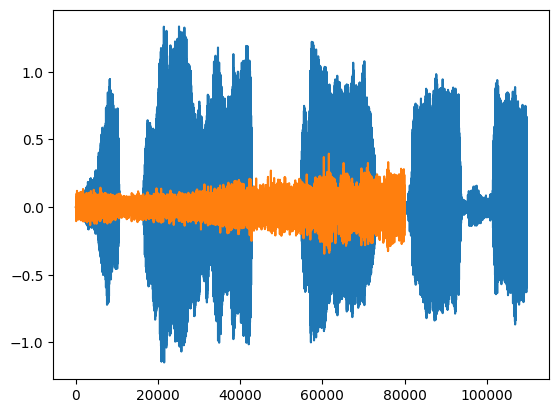

In [9]:
plt.plot(wave) # Blue waveform
plt.plot(nwave) # Orange waveform
plt.show()

# 5. Creating Tensorflow Dataset

In [10]:
# Defining paths to positive and negative data

POS = os.path.join('data', 'cry')
NEG = os.path.join('data', 'not_cry')

In [11]:
# Create Tensorflow Dataset

pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [12]:
pos.as_numpy_iterator().next()

b'data\\cry\\baby_cry (33).wav'

In [23]:
neg.as_numpy_iterator().next()

b'data\\not_cry\\noise (158).wav'

In [17]:
# Add labels and Combine Positive and Negative Samples

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [19]:
data.as_numpy_iterator().next()

(b'data\\cry\\baby_cry (483).wav', 1.0)

# 6. Determine Average Length of a Cry files

In [25]:
# Calculate Wave Cycle Length

lengths = []
for file in os.listdir(os.path.join('data', 'cry')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'cry', file))
    lengths.append(len(tensor_wave))

In [31]:
lengths

[109440,
 107520,
 110720,
 111360,
 110720,
 110720,
 111040,
 112000,
 112000,
 112000,
 104640,
 104640,
 111040,
 112000,
 112000,
 112000,
 112000,
 112000,
 110720,
 110720,
 111040,
 111040,
 112000,
 110400,
 112000,
 112000,
 112000,
 112000,
 112000,
 106560,
 112000,
 109760,
 110080,
 111360,
 111360,
 110080,
 110720,
 109760,
 109760,
 111040,
 108480,
 111360,
 112000,
 111360,
 112960,
 111040,
 112960,
 112960,
 112960,
 112960,
 112960,
 112960,
 112640,
 112960,
 112000,
 112000,
 107520,
 112000,
 112000,
 112000,
 110400,
 110720,
 112000,
 112000,
 106560,
 105920,
 106560,
 106880,
 106880,
 112000,
 111040,
 111040,
 111360,
 112000,
 112000,
 112000,
 112000,
 110400,
 106560,
 112000,
 112640,
 112960,
 112640,
 108480,
 112000,
 112000,
 112000,
 112000,
 108480,
 112000,
 108480,
 111360,
 110720,
 110720,
 110080,
 109760,
 112640,
 112960,
 110400,
 112000,
 112000,
 112960,
 112960,
 111040,
 110400,
 112000,
 112000,
 109760,
 110080,
 109760,
 109760,
 

In [32]:
# Calculate Mean, Min and Max

mean_cry = tf.math.reduce_mean(lengths)
min_cry = tf.math.reduce_min(lengths)
max_cry = tf.math.reduce_max(lengths)

In [35]:
print(mean_cry)
print(min_cry)
print(max_cry)

tf.Tensor(106768, shape=(), dtype=int32)
tf.Tensor(80000, shape=(), dtype=int32)
tf.Tensor(112960, shape=(), dtype=int32)


# 7. Build Preprocessing Function to Convert to Spectrogram

In [36]:
# Preprocessing function

def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

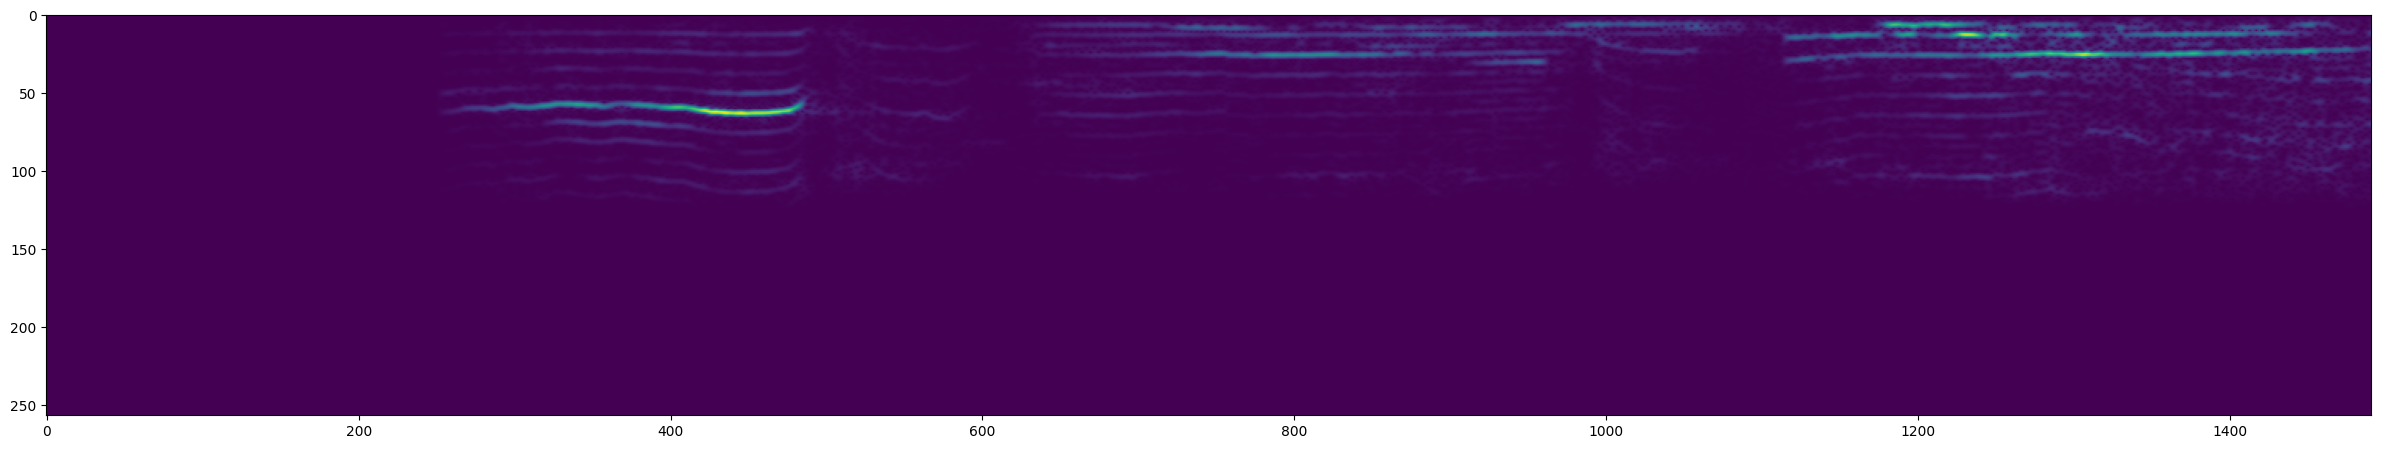

In [59]:
# Testing Out the Function and Vizulazing the Spectrogram for positives

filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

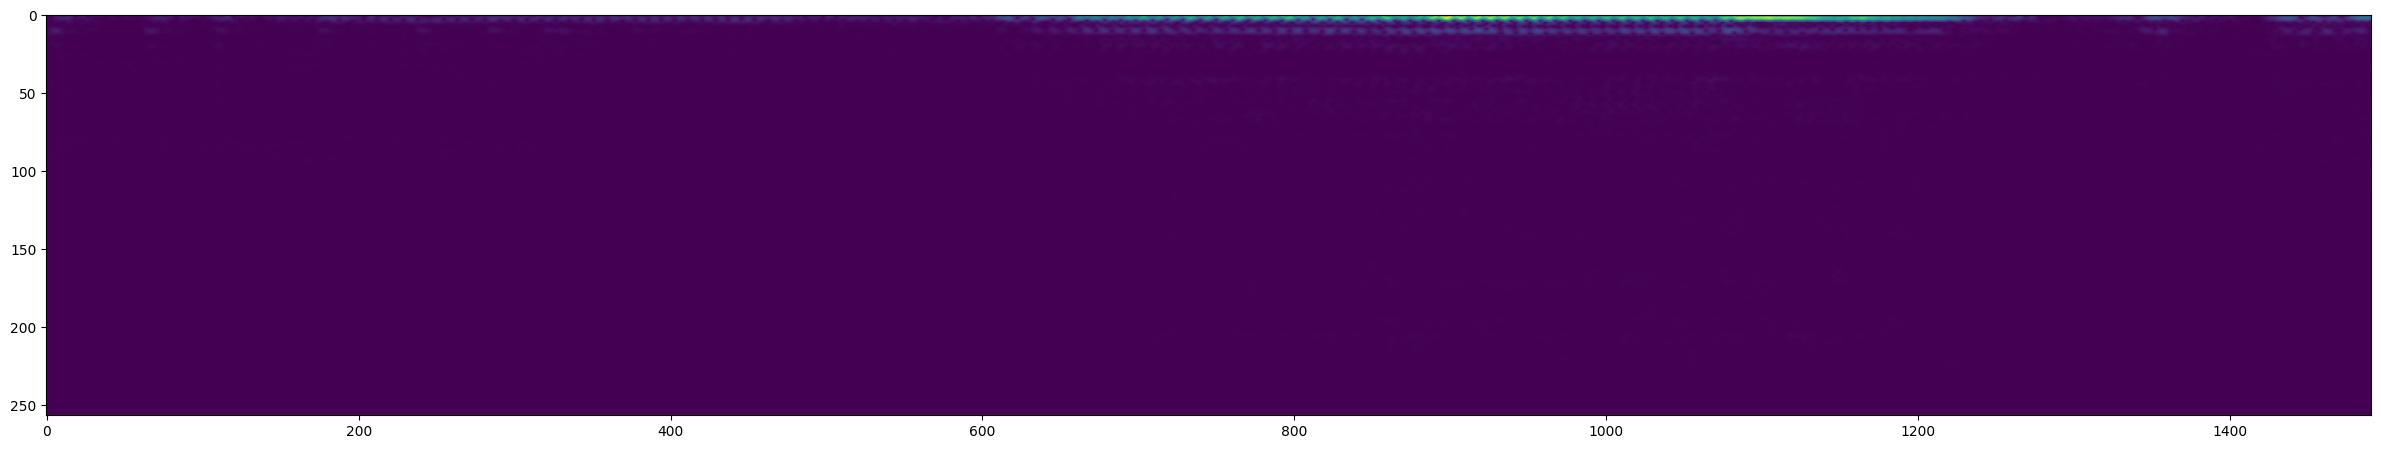

In [67]:
# Testing Out the Function and Vizulazing the Spectrogram for negatives

filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()